In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix, \
    ConfusionMatrixDisplay, recall_score, precision_score, f1_score, fbeta_score, make_scorer

from xgboost import XGBClassifier

from collections import Counter
from tqdm import tqdm
import joblib
from joblib import dump

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [2]:
df = pd.read_csv('df_final.csv')
df['TARGET'] = 1 - df['TARGET']
print('Le DataFrame contient', df.shape[0], 'lignes qui sont nos clients, et',
      df.shape[1], 'colonnes (dont l\'ID du client et sa target)')
df.head()

Le DataFrame contient 252133 lignes qui sont nos clients, et 517 colonnes (dont l'ID du client et sa target)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003,1,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006,1,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007,1,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


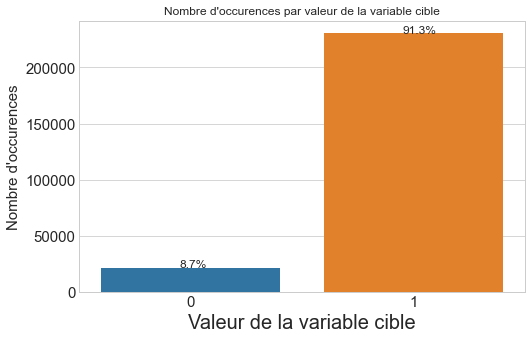

In [3]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    plt.show()


fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['TARGET'].value_counts().index,
                 y=df['TARGET'].value_counts().values)
plt.title('Nombre d\'occurences par valeur de la variable cible')
plt.xlabel('Valeur de la variable cible', fontsize=20)
plt.ylabel('Nombre d\'occurences', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

without_hue(ax, df['TARGET'])

In [4]:
df['TARGET'].value_counts()

1    230298
0     21835
Name: TARGET, dtype: int64

La variable ```TARGET``` est notre variable cible. Elle vaut *0* lorsque le client a des difficultés de paiement (il a payé en retard d'au moins X jours au moins une fois dans les Y premiers remboursements du prêt) et *1* sinon.

## Préparation des données

### Séparation en sous-ensemble d'entraînement et de test

In [5]:
X = df.loc[:, df.columns != 'TARGET']
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(176493, 516)
(75640, 516)
(176493,)
(75640,)


### Traitement des valeurs manquantes

In [7]:
columns_int = list(X_train.select_dtypes(include=['uint8', 'int64']).columns)
columns_float = list(X_train.select_dtypes(include=['float64']).columns)

In [8]:
X_train_preprocessed = X_train.copy()
X_test_preprocessed = X_test.copy()

Application de SimpleImputer pour remplacer les Nan selon 2 stratégies:
- Si la variable est discrète, on remplace Nan par la valeur la plus fréquente pour cette variable.
- Si la variable est continue, on remplace Nan par la moyenne des valeurs pour cette variable.

In [9]:
imp_most_frequent = SimpleImputer(strategy="most_frequent")
imp_most_frequent.fit(X_train_preprocessed[columns_int])
X_train_preprocessed[columns_int] = imp_most_frequent.transform(X_train_preprocessed[columns_int])
X_test_preprocessed[columns_int] = imp_most_frequent.transform(X_test_preprocessed[columns_int])

imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit(X_train_preprocessed[columns_float])
X_train_preprocessed[columns_float] = imp_mean.transform(X_train_preprocessed[columns_float])
X_test_preprocessed[columns_float] = imp_mean.transform(X_test_preprocessed[columns_float])

### Normalisation

In [10]:
std_scale_X = RobustScaler().fit(X_train_preprocessed[columns_float])
X_train_preprocessed[columns_float] = std_scale_X.transform(X_train_preprocessed[columns_float])
X_test_preprocessed[columns_float] = std_scale_X.transform(X_test_preprocessed[columns_float])

## Modélisation

In [76]:
def RSE(y_test, predictions):
    y_barre = np.mean(y_test)
    RSE = sum((y_test - predictions)**2)/sum((y_test - y_barre)**2)
    return RSE


def plot_conf_matrix(y_true, y_pred):
    conf_matrix = (confusion_matrix(y_true, y_pred))

    fig = sns.heatmap(conf_matrix, annot=True, cmap='Blues')

    fig.set_title('Matrice de confusion')

    fig.set_xlabel('Valeurs Prédites')
    fig.set_ylabel('Valeurs Réelles')

    fig.xaxis.set_ticklabels(['Négatifs', 'Positifs'])
    fig.yaxis.set_ticklabels(['Négatifs', 'Positifs'])

    plt.show()


def Performances(model, X_test, y_test, predictions, seuil=0.5, cv=True):
    scores = []

    if cv:
        # Cross-validation score
        cv_score = model.best_score_
        print('Cross Validation score = {:.2f}'.format(cv_score))
        scores.append(cv_score)
    else:
        scores.append('')
    
    # Test score
    test_score = model.score(X_test, y_test)
    print('Test score = {:.2f}'.format(test_score))
    scores.append(test_score)

    # RMSE et MSE
    MSE = mean_squared_error(y_test, predictions, squared=True)
    print('RMSE = {:.2f}'.format(MSE**(1/2)))
    print('MSE = {:.2f}'.format(MSE))
    scores.append(MSE**(1/2))
    scores.append(MSE)

    # RSE
    RSE_ = RSE(y_test, predictions)
    print('RSE = {:.2f}'.format(RSE_))
    scores.append(RSE_)

    # ROC AUC score
    ROC_AUC = roc_auc_score(y_test, predictions)
    print('ROC_AUC = {:.2f}'.format(ROC_AUC))
    scores.append(ROC_AUC)

    # Courbe ROC
    [fpr, tpr, thr] = roc_curve(y_test, predictions)
    scores.append([fpr, tpr, thr])
    plt.plot(fpr, tpr, color='coral', lw=2, label='Classifier')
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

    y_pred = pd.Series(predictions).apply(lambda x: 1 if x >= seuil else 0)
    # Matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='')

    # Rappel et précision
    Recall = recall_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    print('Recall = {:.2f}'.format(Recall))
    print('Precision = {:.2f}'.format(Precision))
    scores.append(Recall)
    scores.append(Precision)

    # F1-score
    F1 = f1_score(y_test, y_pred)
    print('Score F1 = {:.2f}'.format(F1))
    scores.append(F1)

    return scores

In [12]:
np.random.seed(5)
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

1. DummyClassifier
2. RandomForestClassifier
3. LGBM
4. XGBoost
5. Logistic Regression

### Dummy Classifier (Baseline)

In [13]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0)

dummy.fit(X_train_preprocessed, y_train)
prediction_dummy = dummy.predict_proba(X_test_preprocessed)

Test score = 0.91
RMSE = 0.29
MSE = 0.09
RSE = 1.09
ROC_AUC = 0.50


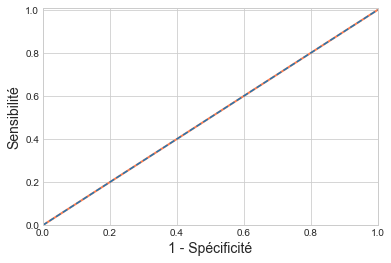

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


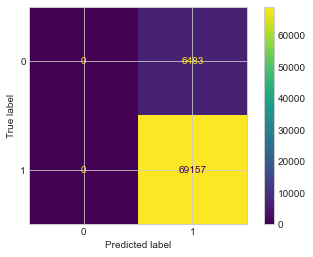

In [77]:
perf_dummy = Performances(dummy, X_test_preprocessed, y_test, prediction_dummy[:, 1], cv=False)

In [15]:
# Enregistrement du modèle
joblib.dump(dummy, 'dummy.joblib')

# dummy_loaded = joblib.load('dummy.joblib')

['dummy.joblib']

## GridSearch

### Random Forest Classifier

In [16]:
param_RF = {'n_estimators': [100, 150, 200],
            'max_depth': [3, 5, None],
            'bootstrap': [True, False],
            'min_samples_leaf': [2, 4]}

RF = GridSearchCV(RandomForestClassifier(random_state=0),
                  param_grid=param_RF,
                  cv=cv_strat,
                  scoring='roc_auc',
                  verbose=3)

# RF.fit(X_train_preprocessed, y_train)
RF = joblib.load('RF.joblib')

prediction_RF = RF.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}
Cross Validation score = 0.74
Test score = 0.75
RMSE = 0.28
MSE = 0.08
RSE = 0.97
ROC_AUC = 0.75


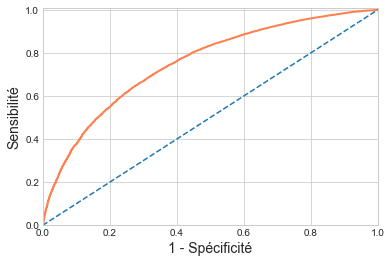

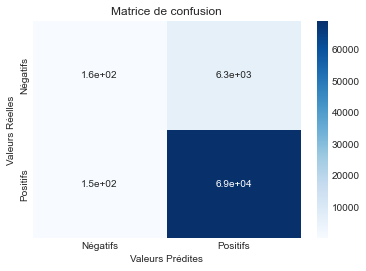

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


In [17]:
print('Meilleurs hyperparamètres : ' + str(RF.best_params_))

perf_RF = Performances(RF, X_test_preprocessed, y_test, prediction_RF[:, 1])

In [18]:
# Enregistrement du modèle
# joblib.dump(RF, 'RF.joblib')

### LightGBM

In [19]:
param_LGBM = {'max_depth': [5, 10, 15],
              'num_leaves': [20, 30],
              'n_estimators': [100, 300, 500]}

LGBM = GridSearchCV(LGBMClassifier(random_state=0),
                    param_grid=param_LGBM,
                    cv=cv_strat,
                    scoring='roc_auc',
                    verbose=3)

# LGBM.fit(X_train_preprocessed, y_train)
LGBM = joblib.load('LGBM.joblib')

prediction_LGBM = LGBM.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'class_weight': {0: 1, 1: 1}, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 20}
Cross Validation score = 0.77
Test score = 0.78
RMSE = 0.26
MSE = 0.07
RSE = 0.89
ROC_AUC = 0.78


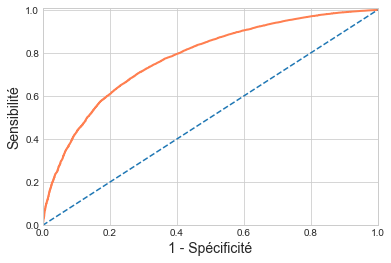

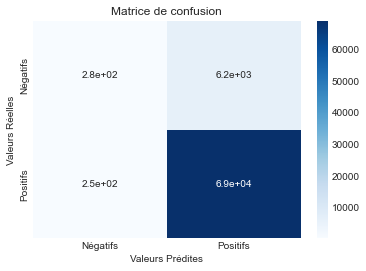

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


In [20]:
print('Meilleurs hyperparamètres : ' + str(LGBM.best_params_))

perf_LGBM = Performances(LGBM, X_test_preprocessed, y_test, prediction_LGBM[:, 1])

In [21]:
# Enregistrement du modèle
# joblib.dump(LGBM, 'LGBM.joblib')

### XGBoost

In [22]:
param_XGB = {'max_depth': [5, 10, 15],
             'learning_rate': [0.1, 0.15, 0.3],
             'n_estimators': [100, 300, 500]}

XGB = GridSearchCV(XGBClassifier(random_state=0),
                   param_grid=param_XGB,
                   cv=cv_strat,
                   scoring='roc_auc',
                   verbose=3)

# XGB.fit(X_train_preprocessed, y_train)
XGB = joblib.load('XGB.joblib')

prediction_XGB = XGB.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 1}
Cross Validation score = 0.77
Test score = 0.78
RMSE = 0.26
MSE = 0.07
RSE = 0.89
ROC_AUC = 0.78


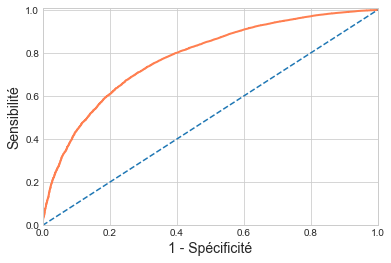

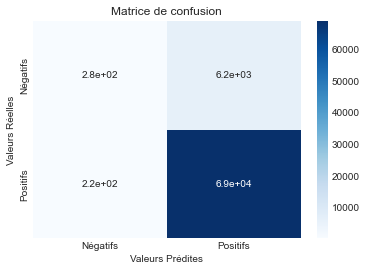

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


In [23]:
print('Meilleurs hyperparamètres : ' + str(XGB.best_params_))

perf_XGB = Performances(XGB, X_test_preprocessed, y_test, prediction_XGB[:, 1])

In [24]:
# Enregistrement du modèle
# joblib.dump(XGB, 'XGB.joblib')

### Logistic Regression

In [25]:
param_Logistic = {'C': np.logspace(-4, 4, 20),
                  'penalty': ['none', 'l2']}

Logistic = GridSearchCV(LogisticRegression(random_state=0),
                        param_grid=param_Logistic,
                        cv=cv_strat,
                        scoring='roc_auc',
                        verbose=3)

# Logistic.fit(X_train_preprocessed, y_train)
Logistic = joblib.load('Logistic.joblib')

prediction_Logistic = Logistic.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'C': 0.012742749857031334, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2'}
Cross Validation score = 0.59
Test score = 0.59
RMSE = 0.28
MSE = 0.08
RSE = 1.00
ROC_AUC = 0.59


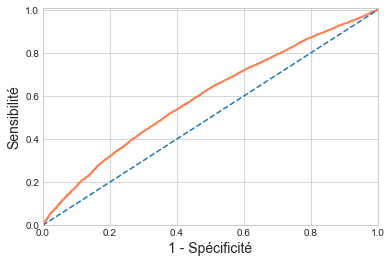

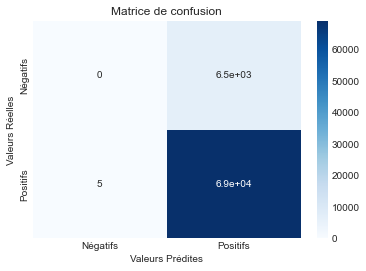

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


In [26]:
print('Meilleurs hyperparamètres : ' + str(Logistic.best_params_))

perf_Logistic = Performances(Logistic, X_test_preprocessed, y_test, prediction_Logistic[:, 1])

In [27]:
# Enregistrement du modèle
# joblib.dump(Logistic, 'Logistic.joblib')

### Comparaison des performances

In [28]:
def displayPerformances(listePerf):
    listeCV = [perf[0] for perf in listePerf]
    listeTest = [perf[1] for perf in listePerf]
    listeRMSE = [perf[2] for perf in listePerf]
    listeMSE = [perf[3] for perf in listePerf]
    listeRSE = [perf[4] for perf in listePerf]
    listeAUC = [perf[5] for perf in listePerf]
    listeRecall = [perf[7] for perf in listePerf]
    listePrecision = [perf[8] for perf in listePerf]
    listeF1 = [perf[9] for perf in listePerf]
    listeModeles = ['Dummy Classifier', 'Random Forest', 'LGBM',
                    'XGBoost', 'Logistic Regression']
    score = pd.DataFrame()
    score['Modèle'] = listeModeles
    score['Score de Cross-Validation'] = listeCV
    score['Score de test'] = listeTest
    score['RMSE'] = listeRMSE
    score['MSE'] = listeMSE
    score['RSE'] = listeRSE
    score['AUC'] = listeAUC
    score['Rappel'] = listeRecall
    score['Précision'] = listePrecision
    score['F1'] = listeF1

    fig = plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Modèle', y='AUC', data=score)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title('Score AUC des différents modèles testés',
            fontsize=20)
    plt.xlabel('Les différents modèles testés', fontsize=20)
    plt.ylabel('Score AUC', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    fig = plt.figure(figsize=(12, 8))
    for perf in listePerf:
        [fpr, tpr, thr] = perf[6]
        plt.plot(fpr, tpr, lw=2)
    plt.legend(listeModeles)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

    new_score = score.T
    new_score.columns = new_score.iloc[0, :]
    new_score.drop(new_score.loc[new_score['Dummy Classifier'] == 'Dummy Classifier'].index, inplace=True)
    return new_score

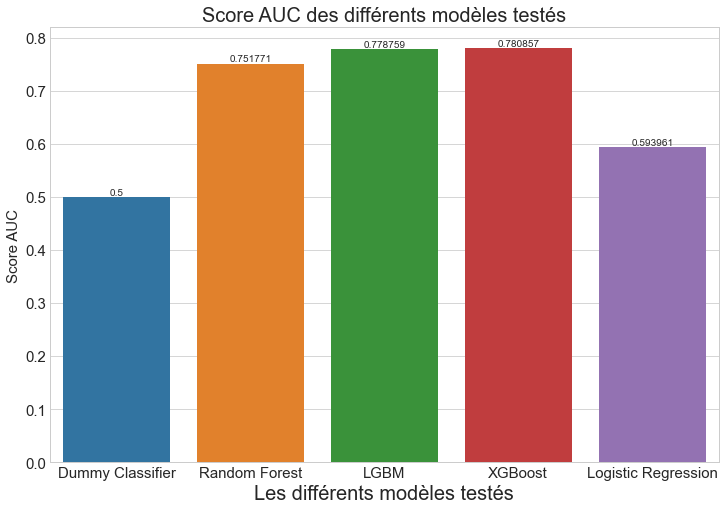

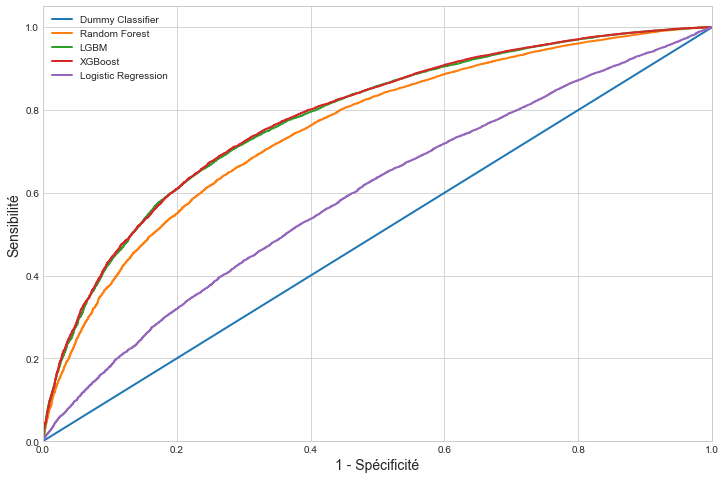

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.743477,0.769802,0.771508,0.585248
Score de test,0.914291,0.751771,0.778759,0.780857,0.593961
RMSE,0.29276,0.275714,0.264763,0.264334,0.279719
MSE,0.085709,0.076018,0.070099,0.069872,0.078243
RSE,1.093743,0.970084,0.894549,0.891653,0.998471
AUC,0.5,0.751771,0.778759,0.780857,0.593961
Rappel,1.0,0.997874,0.996428,0.996862,0.999928
Précision,0.914291,0.91609,0.917479,0.917451,0.914286
F1,0.955227,0.955235,0.955325,0.955509,0.955191


In [29]:
listePerf = [perf_dummy, perf_RF, perf_LGBM, perf_XGB, perf_Logistic]
df_score = displayPerformances(listePerf)
df_score.head(df_score.shape[0])

## GridSearch + SMOTE

In [30]:
Counter(y_train)

Counter({0: 15352, 1: 161141})

In [31]:
Smote = SMOTE(sampling_strategy=0.5)
X_SMOTE, y_SMOTE = Smote.fit_resample(X_train_preprocessed, y_train)

In [32]:
Counter(y_SMOTE)

Counter({0: 80570, 1: 161141})

### Random Forest Classifier

In [33]:
RF_SMOTE = GridSearchCV(RandomForestClassifier(random_state=0),
                        param_grid=param_RF,
                        cv=cv_strat,
                        scoring='roc_auc',
                        verbose=3)

# RF_SMOTE.fit(X_SMOTE, y_SMOTE)
RF_SMOTE = joblib.load('RF_SMOTE.joblib')

prediction_RF_SMOTE = RF_SMOTE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Cross Validation score = 0.96
Test score = 0.72
RMSE = 0.27
MSE = 0.07
RSE = 0.95
ROC_AUC = 0.72


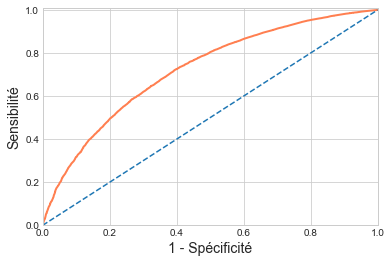

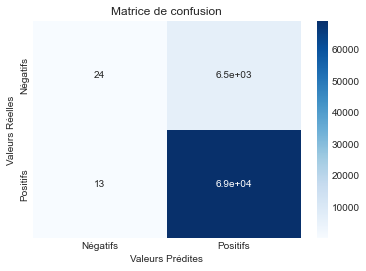

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


In [34]:
print('Meilleurs hyperparamètres : ' + str(RF_SMOTE.best_params_))

perf_RF_SMOTE = Performances(RF_SMOTE, X_test_preprocessed, y_test, prediction_RF_SMOTE[:, 1])

In [35]:
# Enregistrement du modèle
# joblib.dump(RF_SMOTE, 'RF_SMOTE.joblib')

### LightGBM

In [36]:
LGBM_SMOTE = GridSearchCV(LGBMClassifier(random_state=0),
                          param_grid=param_LGBM,
                          cv=cv_strat,
                          scoring='roc_auc',
                          verbose=3)

# LGBM_SMOTE.fit(X_SMOTE, y_SMOTE)
LGBM_SMOTE = joblib.load('LGBM_SMOTE.joblib')

prediction_LGBM_SMOTE = LGBM_SMOTE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 500, 'num_leaves': 30}
Cross Validation score = 0.96
Test score = 0.77
RMSE = 0.27
MSE = 0.07
RSE = 0.90
ROC_AUC = 0.77


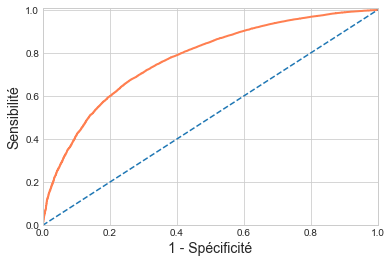

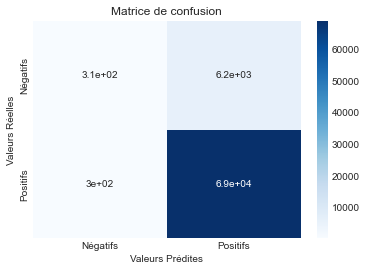

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


In [37]:
print('Meilleurs hyperparamètres : ' + str(LGBM_SMOTE.best_params_))

perf_LGBM_SMOTE = Performances(LGBM_SMOTE, X_test_preprocessed, y_test, prediction_LGBM_SMOTE[:, 1])

In [38]:
# Enregistrement du modèle
# joblib.dump(LGBM_SMOTE, 'LGBM_SMOTE.joblib')

### XGBoost

In [39]:
XGB_SMOTE = GridSearchCV(XGBClassifier(random_state=0),
                         param_grid=param_XGB,
                         cv=cv_strat,
                         scoring='roc_auc',
                         verbose=3)

# XGB_SMOTE.fit(X_SMOTE, y_SMOTE)
XGB_SMOTE = joblib.load('XGB_SMOTE.joblib')

prediction_XGB_SMOTE = XGB_SMOTE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
Cross Validation score = 0.96
Test score = 0.77
RMSE = 0.28
MSE = 0.08
RSE = 0.99
ROC_AUC = 0.77


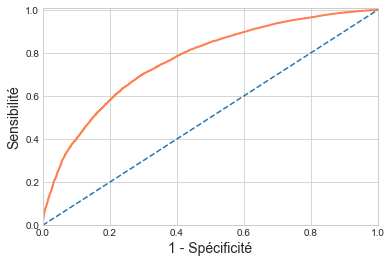

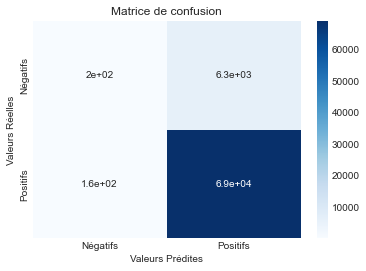

Recall = 1.00
Precision = 0.92
Score F1 = 0.96


In [40]:
print('Meilleurs hyperparamètres : ' + str(XGB_SMOTE.best_params_))

perf_XGB_SMOTE = Performances(XGB_SMOTE, X_test_preprocessed, y_test, prediction_XGB_SMOTE[:, 1])

In [41]:
# Enregistrement du modèle
# joblib.dump(XGB_SMOTE, 'XGB_SMOTE.joblib')

### Logistic Regression

In [42]:
Logistic_SMOTE = GridSearchCV(LogisticRegression(random_state=0),
                              param_grid=param_Logistic,
                              cv=cv_strat,
                              scoring='roc_auc',
                              verbose=3)

# Logistic_SMOTE.fit(X_SMOTE, y_SMOTE)
Logistic_SMOTE = joblib.load('Logistic_SMOTE.joblib')

prediction_Logistic_SMOTE = Logistic_SMOTE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'C': 3792.690190732246, 'penalty': 'l2'}
Cross Validation score = 0.60
Test score = 0.60
RMSE = 0.37
MSE = 0.14
RSE = 1.75
ROC_AUC = 0.60


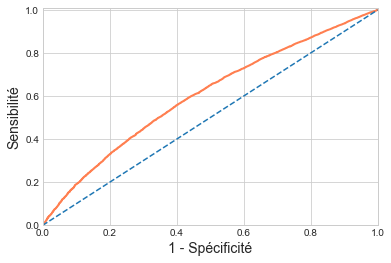

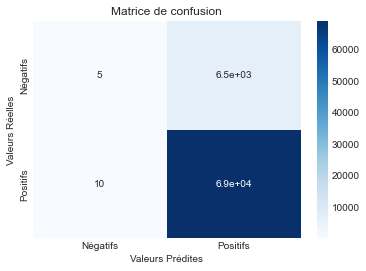

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


In [43]:
print('Meilleurs hyperparamètres : ' + str(Logistic_SMOTE.best_params_))

perf_Logistic_SMOTE = Performances(Logistic_SMOTE, X_test_preprocessed, y_test, prediction_Logistic_SMOTE[:, 1])

In [44]:
# Enregistrement du modèle
# joblib.dump(Logistic_SMOTE, 'Logistic_SMOTE.joblib')

### Comparaison des performances

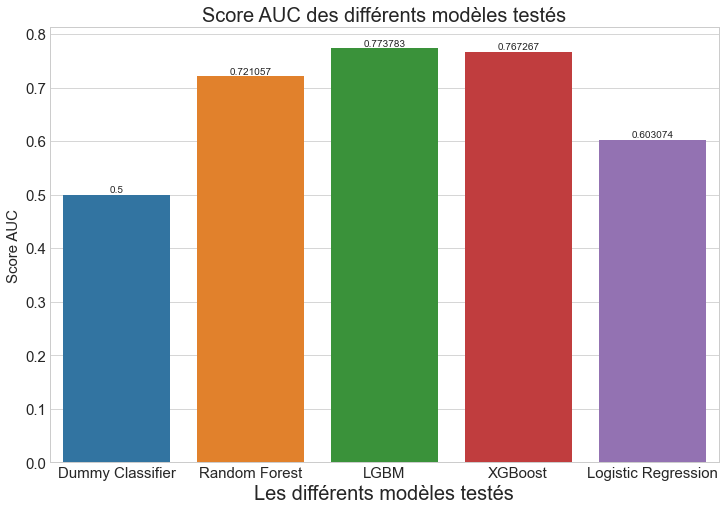

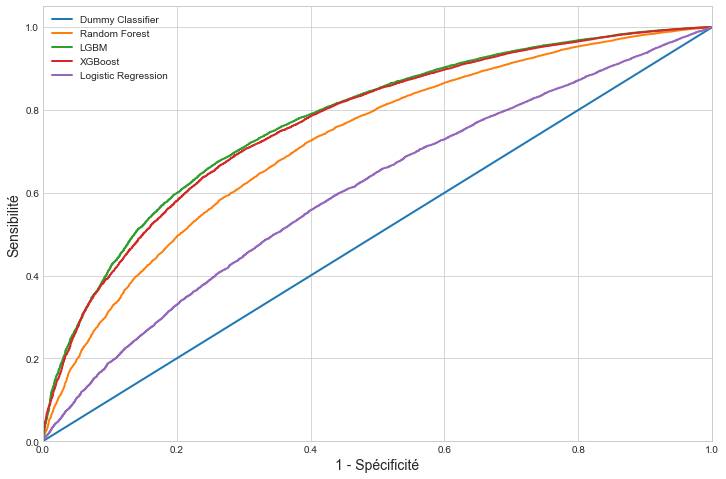

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.955915,0.955906,0.958984,0.60114
Score de test,0.914291,0.721057,0.773783,0.767267,0.603074
RMSE,0.29276,0.273179,0.265634,0.278214,0.369855
MSE,0.085709,0.074627,0.070561,0.077403,0.136793
RSE,1.093743,0.952328,0.900445,0.987758,1.745636
AUC,0.5,0.721057,0.773783,0.767267,0.603074
Rappel,1.0,0.999812,0.995604,0.997744,0.999855
Précision,0.914291,0.914567,0.917685,0.916555,0.91434
F1,0.955227,0.955292,0.955058,0.955428,0.955188


In [45]:
listePerf_SMOTE = [perf_dummy, perf_RF_SMOTE, perf_LGBM_SMOTE, perf_XGB_SMOTE, perf_Logistic_SMOTE]
df_score_SMOTE = displayPerformances(listePerf_SMOTE)
df_score_SMOTE.head(df_score_SMOTE.shape[0])

## GridSearch + SMOTE SE

In [46]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_SMOTE_SE, y_SMOTE_SE = pipeline.fit_resample(X_train_preprocessed, y_train)

### Random Forest Classifier

In [48]:
RF_SMOTE_SE = GridSearchCV(RandomForestClassifier(random_state=0),
                           param_grid=param_RF,
                           cv=cv_strat,
                           scoring='roc_auc',
                           verbose=3)

# RF_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
RF_SMOTE_SE = joblib.load('RF_SMOTE_SE.joblib')

prediction_RF_SMOTE_SE = RF_SMOTE_SE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}
Cross Validation score = 0.76
Test score = 0.75
RMSE = 0.35
MSE = 0.12
RSE = 1.54
ROC_AUC = 0.75


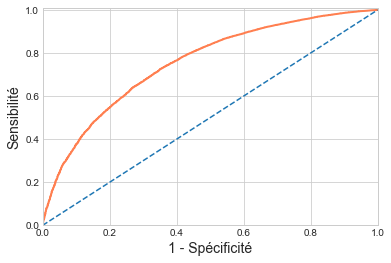

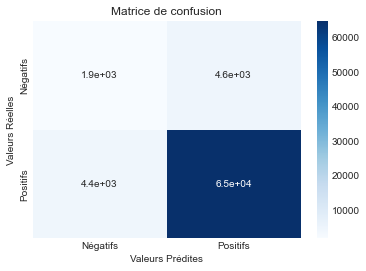

Recall = 0.94
Precision = 0.93
Score F1 = 0.93


In [49]:
print('Meilleurs hyperparamètres : ' + str(RF_SMOTE_SE.best_params_))

perf_RF_SMOTE_SE = Performances(RF_SMOTE_SE, X_test_preprocessed, y_test, prediction_RF_SMOTE_SE[:, 1])

In [50]:
# Enregistrement du modèle
# joblib.dump(RF_SMOTE_SE, 'RF_SMOTE_SE.joblib')

### LightGBM

In [52]:
LGBM_SMOTE_SE = GridSearchCV(LGBMClassifier(random_state=0),
                             param_grid=param_LGBM,
                             cv=cv_strat,
                             scoring='roc_auc',
                             verbose=3)

# LGBM_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
LGBM_SMOTE_SE = joblib.load('LGBM_SMOTE_SE.joblib')

prediction_LGBM_SMOTE_SE = LGBM_SMOTE_SE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 300, 'num_leaves': 20}
Cross Validation score = 0.78
Test score = 0.78
RMSE = 0.34
MSE = 0.12
RSE = 1.50
ROC_AUC = 0.78


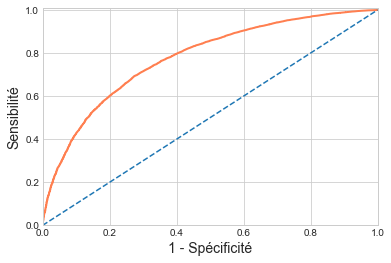

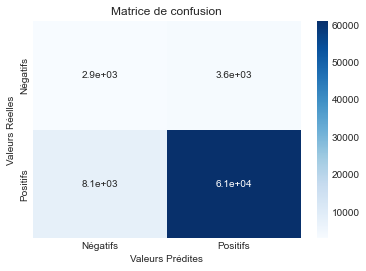

Recall = 0.88
Precision = 0.94
Score F1 = 0.91


In [53]:
print('Meilleurs hyperparamètres : ' + str(LGBM_SMOTE_SE.best_params_))

perf_LGBM_SMOTE_SE = Performances(LGBM_SMOTE_SE, X_test_preprocessed, y_test, prediction_LGBM_SMOTE_SE[:, 1])

In [54]:
# Enregistrement du modèle
# joblib.dump(LGBM_SMOTE_SE, 'LGBM_SMOTE_SE.joblib')

### XGBoost

In [55]:
XGB_SMOTE_SE = GridSearchCV(XGBClassifier(random_state=0),
                            param_grid=param_XGB,
                            cv=cv_strat,
                            scoring='roc_auc',
                            verbose=3)

# XGB_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
XGB_SMOTE_SE = joblib.load('XGB_SMOTE_SE.joblib')

prediction_XGB_SMOTE_SE = XGB_SMOTE_SE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Cross Validation score = 0.78
Test score = 0.78
RMSE = 0.34
MSE = 0.12
RSE = 1.50
ROC_AUC = 0.78


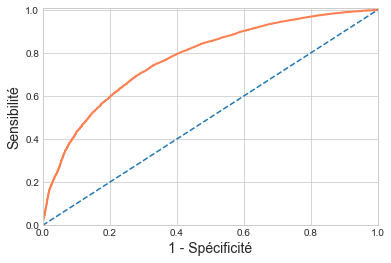

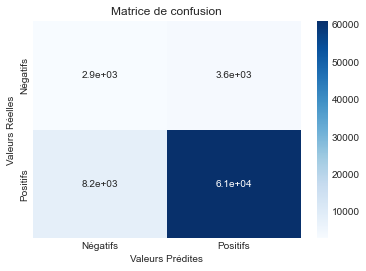

Recall = 0.88
Precision = 0.94
Score F1 = 0.91


In [56]:
print('Meilleurs hyperparamètres : ' + str(XGB_SMOTE_SE.best_params_))

perf_XGB_SMOTE_SE = Performances(XGB_SMOTE_SE, X_test_preprocessed, y_test, prediction_XGB_SMOTE_SE[:, 1])

In [ ]:
# Enregistrement du modèle
# joblib.dump(XGB_SMOTE_SE, 'XGB_SMOTE_SE.joblib')

### Logistic Regression

In [57]:
Logistic_SMOTE_SE = GridSearchCV(LogisticRegression(random_state=0),
                                 param_grid=param_Logistic,
                                 cv=cv_strat,
                                 scoring='roc_auc',
                                 verbose=3)

# Logistic_SMOTE_SE.fit(X_SMOTE_SE, y_SMOTE_SE)
Logistic_SMOTE_SE = joblib.load('Logistic_SMOTE_SE.joblib')

prediction_Logistic_SMOTE_SE = Logistic_SMOTE_SE.predict_proba(X_test_preprocessed)

Meilleurs hyperparamètres : {'C': 10000.0, 'penalty': 'l2'}
Cross Validation score = 0.60
Test score = 0.60
RMSE = 0.37
MSE = 0.14
RSE = 1.75
ROC_AUC = 0.60


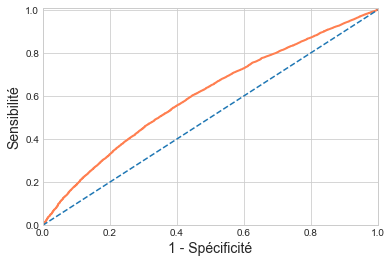

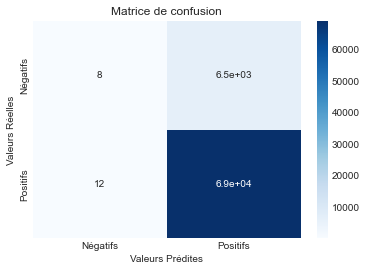

Recall = 1.00
Precision = 0.91
Score F1 = 0.96


In [58]:
print('Meilleurs hyperparamètres : ' + str(Logistic_SMOTE_SE.best_params_))

perf_Logistic_SMOTE_SE = Performances(Logistic_SMOTE_SE, X_test_preprocessed, y_test, prediction_Logistic_SMOTE_SE[:, 1])

In [59]:
# Enregistrement du modèle
# joblib.dump(Logistic_SMOTE_SE, 'Logistic_SMOTE_SE.joblib')

### Comparaison des performances

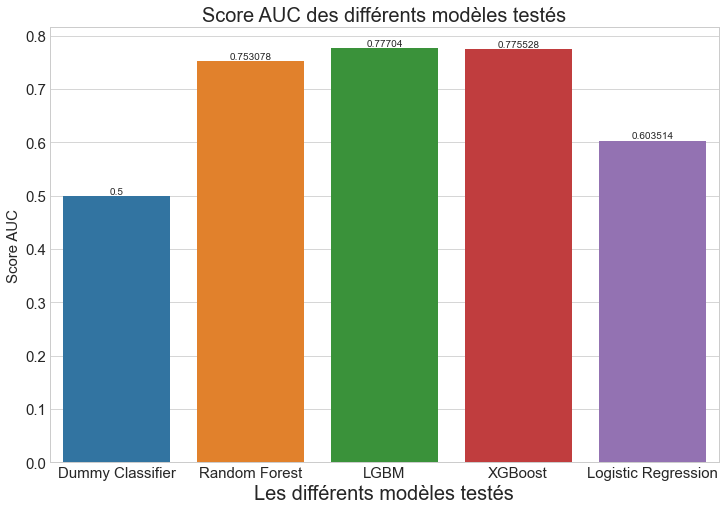

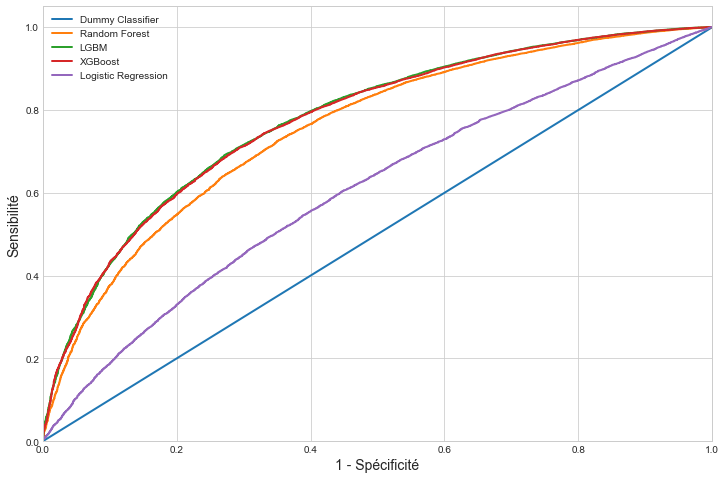

Modèle,Dummy Classifier,Random Forest,LGBM,XGBoost,Logistic Regression
Score de Cross-Validation,,0.757475,0.779674,0.779398,0.598585
Score de test,0.914291,0.753078,0.77704,0.775528,0.603514
RMSE,0.29276,0.347434,0.342805,0.34284,0.370062
MSE,0.085709,0.12071,0.117515,0.117539,0.136946
RSE,1.093743,1.540407,1.499631,1.499942,1.74759
AUC,0.5,0.753078,0.77704,0.775528,0.603514
Rappel,1.0,0.935957,0.883092,0.881603,0.999826
Précision,0.914291,0.933285,0.944627,0.943953,0.914375
F1,0.955227,0.934619,0.912824,0.911713,0.955193


In [60]:
listePerf_SMOTE_SE = [perf_dummy, perf_RF_SMOTE_SE, perf_LGBM_SMOTE_SE, perf_XGB_SMOTE_SE, perf_Logistic_SMOTE_SE]
df_score_SMOTE_SE = displayPerformances(listePerf_SMOTE_SE)
df_score_SMOTE_SE.head(df_score_SMOTE_SE.shape[0])

## Comparaison des performances

In [61]:
def CreateDfScore(df, strategie, dummy=False):
    df_score = df.copy()
    if not dummy:
        df_score.drop('Dummy Classifier', axis=1, inplace=True)

    new_df_score = pd.DataFrame()
    for col in df_score.columns:
        new_df = pd.DataFrame()
        new_df['Score'] = df_score[col]
        new_df['Modèle'] = [col]*new_df.shape[0]
        new_df_score = pd.concat([new_df_score, new_df])

    new_df_score['Stratégie'] = [strategie]*new_df_score.shape[0]
    return new_df_score

df_dummy = CreateDfScore(df_score[['Dummy Classifier']], 'Baseline', dummy=True)
df_grid = CreateDfScore(df_score, 'GridSearch')
df_SMOTE = CreateDfScore(df_score_SMOTE, 'GridSearch + SMOTE')
df_SMOTE_SE = CreateDfScore(df_score_SMOTE_SE, 'GridSearch + SMOTE SE')

df2 = pd.concat([df_dummy, df_grid, df_SMOTE, df_SMOTE_SE], axis=0)
df2.head()
pivoted = df2.pivot(columns=['Stratégie', 'Modèle'])
pivoted = pivoted.reindex(df_score.index)
pivoted = pivoted.droplevel(0, axis=1)
s = pivoted.style.format(na_rep='')
s

## Fonction de coût métier

In [62]:
def cout_metier(y_true, y_pred, poids_fp=10, poids_fn=1):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    return fp*poids_fp + fn*poids_fn

### A l'aide de fbeta_score
Dans notre cas, la valeur *0* est attribuée aux *bons* clients et la valeur *1* aux *mauvais* clients.
Si notre modèle catégorise un *bon* client comme un *mauvais* client (prédiction *1* pour vraie valeur *0*), ce n'est pas très grave. En revanche, il ne faut surtout pas catégoriser un *mauvais* client comme un *bon* client (FP = 0).
Precision = TP / (TP + FP)
Rappel = TP / (TP + FN)
Nous voulons donc une **précision le plus proche possible de 1**. Nous cherchons donc un Beta qui se rapproche de 0.

In [79]:
cout_min = 11*y_test.shape[0]
best_beta = 0

for beta_ in [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]:
    print(beta_)
    scorer = make_scorer(fbeta_score, beta=beta_)
    model = GridSearchCV(LGBMClassifier(random_state=0),
                         param_grid=param_LGBM,
                         cv=cv_strat,
                         scoring=scorer,
                         verbose=3)

    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    cout = cout_metier(y_test, y_pred)
    if cout < cout_min:
        best_beta = beta_
        joblib.dump(model, 'best_model_beta.joblib')

0.5
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=5, n_estimators=100, num_leaves=20;, score=0.930 total time=  22.8s


In [ ]:
best_model_beta = joblib.load('best_model_beta.joblib')
y_pred = y_pred = best_model_beta.predict(X_test_preprocessed)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='')
plt.show()

### En choisissant un seuil
Nous allons tester notre meilleur modèle pour différentes valeurs de seuil afin de sélectionner le meilleur.

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


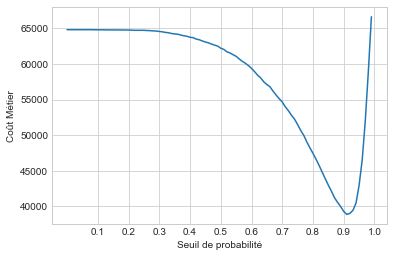

Le coût métier atteint son minimum pour un seuil de probabilité de 0.91


In [68]:
best_model = joblib.load('LGBM.joblib')
cost_function = []
threshold_x = []
predictions = best_model.predict_proba(X_test_preprocessed)
for t in tqdm(range(100)):
    thresh = t/100
    y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= thresh else 0)
    c = cout_metier(y_test, y_pred, poids_fp=10, poids_fn=1)
    cost_function.append(c)
    threshold_x.append(thresh)

plt.plot(threshold_x, cost_function)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Coût Métier")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

min_ = np.argmin(cost_function)
print('Le coût métier atteint son minimum pour un seuil de probabilité de', threshold_x[min_])

Affichons la matrice de confusion pour le seuil de probabilité optimal.

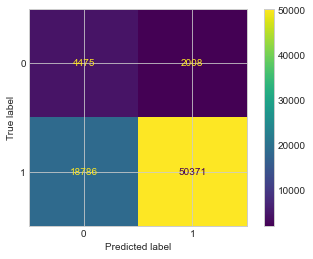

In [78]:
y_pred = pd.Series(predictions[:, 1]).apply(lambda x: 1 if x >= threshold_x[min_] else 0)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='')
plt.show()